In [1]:
import sys
import tensorflow as tf
print(f"Tensor Flow Version: {tf.__version__}")
physical_device = tf.config.experimental.list_physical_devices('GPU')
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.7.0
GPU is available


In [4]:
from matplotlib import pyplot as plt
import pathlib

## create train and validation datasets
DB_PATH = "/content/drive/MyDrive/100daysofML/fashiondb/images"
BUFFER_SIZE = 10000
BATCH_SIZE = 128
IMG_WIDTH = 128
IMG_HEIGHT = 128

def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image,channels=3)

    input_image = tf.cast(image, tf.float32)
    return input_image

def random_crop(input_image):
    cropped_image = tf.image.random_crop(
      input_image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image

def resize(input_image):
    input_image = tf.image.resize(input_image, [IMG_HEIGHT, IMG_WIDTH],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return input_image

def normalize(input_image):
    input_image = (input_image / 255)
    return input_image

@tf.function()
def random_jitter(input_image):
    input_image = random_crop(input_image)

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        
    return input_image

def load_image_train(image_file):
    input_image = load(image_file)
    #input_image = random_jitter(input_image)
    input_image = resize(input_image)
    input_image = normalize(input_image)

    return input_image,input_image

def load_image_test(image_file):
    input_image = load(image_file)
    #input_image = random_jitter(input_image)
    input_image = resize(input_image)
    input_image = normalize(input_image)

    return input_image,input_image

data_dir = pathlib.Path(DB_PATH)
image_count = len(list(data_dir.glob('*.jpg')))
# dataset = tf.data.Dataset.list_files(DB_PATH+'/*.jpg')

In [5]:
dataset = tf.data.Dataset.list_files(DB_PATH+'/*.jpg')

In [6]:
val_size = int(image_count * 0.2)
train_ds = dataset.skip(val_size)
val_ds = dataset.take(val_size)

print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

train_ds = train_ds.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

val_ds = val_ds.map(load_image_test)
val_ds = val_ds.batch(BATCH_SIZE)

35568
8892


FileNotFoundError: ignored

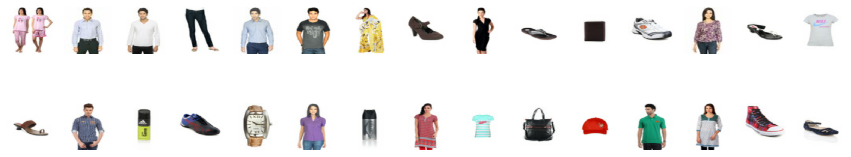

In [7]:
#image_batch = next(iter(train_ds))

plt.figure(figsize=(15, 5))
for images,targets in val_ds.take(1):
    for i in range(30):
        ax = plt.subplot(3, 15, i + 1)
        plt.imshow(images[i].numpy().astype("float32"))
        plt.axis("off")

import os
os.mkdir("Images")
plt.savefig("/Images/Visualizations.jpg")

In [8]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing import image

import tensorflow.keras.backend as K

latent_dim = 256  # Number of latent dimension parameters

input_img = Input(shape=(128, 128, 3))

x = Conv2D(32, (3, 3), activation='relu', padding='same', strides=2)(input_img)
x = BatchNormalization()(x)

x = Conv2D(16, (3, 3), activation='relu', padding='same', strides=2)(x)
x = BatchNormalization()(x)

x = Conv2D(4, (3, 3), activation='relu', padding='same', strides=2)(x)
x = BatchNormalization()(x)

shape_before_flattening = K.int_shape(x)
print(shape_before_flattening)
x = Flatten()(x)

z_mu = Dense(latent_dim)(x)
z_log_sigma = Dense(latent_dim, kernel_initializer='zeros',bias_initializer='zeros')(x)

(None, 16, 16, 4)


In [9]:
# sampling function
def sampling(args):
    z_mu, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mu)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mu + K.exp(z_log_sigma) * epsilon

# sample vector from the latent distribution
z = Lambda(sampling)([z_mu, z_log_sigma])

encoder = Model(input_img,z)

encoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [10]:
# decoder takes the latent distribution sample as input
decoder_input = Input(K.int_shape(z)[1:])
x = Dense(4096, activation='relu', name="intermediate_decoder", input_shape=(latent_dim,))(decoder_input)
x = Reshape((8,8,64))(x)

x = Conv2DTranspose(32, (3, 3),strides= 2, padding='same')(x)
x = BatchNormalization()(x)

x = Conv2DTranspose(16, (3, 3),strides= 2, padding='same')(x)
x = BatchNormalization()(x)

x = Conv2DTranspose(8, (3, 3),strides= 2, padding='same')(x)
x = BatchNormalization()(x)

x = Conv2DTranspose(3, (3, 3),strides= 2, padding='same', activation='sigmoid')(x)


# decoder model statement
decoder = Model(decoder_input, x)

# apply the decoder to the sample from the latent distribution
pred = decoder(z)

decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256)]             0         
                                                                 
 intermediate_decoder (Dense  (None, 4096)             1052672   
 )                                                               
                                                                 
 reshape (Reshape)           (None, 8, 8, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 32)       18464     
 nspose)                                                         
                                                                 
 batch_normalization_3 (Batc  (None, 16, 16, 32)       128       
 hNormalization)                                                 
                                                           

In [11]:
from tensorflow.keras.metrics import binary_crossentropy

def vae_loss(x, pred):
    x = K.flatten(x)
    pred = K.flatten(pred)
    # Reconstruction loss
    #reconst_loss = 100 * binary_crossentropy(x, pred)
    reconst_loss = 1000*K.mean(K.square(x - pred))
    
    # KL divergence
    kl_loss = -0.5 * K.mean(1 + z_log_sigma - K.square(z_mu) - K.exp(z_log_sigma), axis=-1)
    
    return (reconst_loss + kl_loss)

In [12]:
# VAE model statement
vae = Model(input_img,pred)
vae.add_loss(vae_loss(input_img,pred))
optimizer = Adam(learning_rate=0.0005)
vae.compile(optimizer=optimizer, loss=None)

vae.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                            

In [1]:
from keras.callbacks import EarlyStopping
from os import path

# run the model
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=5, mode='auto')

if(path.exists("/checkpoints")):
    vae.load_weights("/checkpoints/vae")
else:
    history = vae.fit(train_ds, epochs=5, validation_data=val_ds, callbacks=[early_stopping],verbose=1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    vae.save_weights("/checkpoints/vae")

NameError: ignored

In [ ]:
from PIL import Image
from sklearn.manifold import TSNE
from scipy.spatial import distance

max_dim = 50

def visualize_space(X,images,outfile):

    #D = distance.squareform(distance.pdist(X), "sqeuclidean")
    tsne = TSNE(n_components=2, learning_rate='auto', init='random', square_distances=True).fit_transform(X)
    tx, ty = tsne[:,0], tsne[:,1]
    tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
    ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))
    width = 10000
    height = 5000


    full_image = Image.new('RGBA', (width, height))
    for img, x, y in zip(images, tx, ty):
        img = np.array(img)
        tile = Image.fromarray(np.uint8(img*255))
        full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)), mask=tile.convert('RGBA'))

    plt.figure(figsize = (66,50))
    plt.imshow(full_image)
    plt.axis("off")
    full_image.save(outfile)

In [ ]:
# Project sample of images from validation set into Latent Space
vis_imgs = []
latent_space = np.zeros((BATCH_SIZE*40,256))
xi = 0
for input_images,output_images in val_ds.take(40):
    latent_vec = encoder(input_images)
    latent_space[xi:xi+BATCH_SIZE,:] = np.array(latent_vec)
    xi = xi + BATCH_SIZE
    for i in range(BATCH_SIZE):
        vis_imgs.append(tf.keras.preprocessing.image.img_to_array(input_images[i]))
print("Dimension of Latent Space:")
print(latent_space.shape)

In [ ]:
visualize_space(latent_space,vis_imgs,"Latent-fashiondb.png")

In [ ]:
from scipy.stats import norm
import numpy as np

fig = plt.figure(figsize=(15, 5))

for input_images,output_images in val_ds.take(1):
    latent_vec = encoder(input_images)
    reconst_vec = decoder.predict(latent_vec)
    for i in range(25):
        ax = fig.add_subplot(5, 5, i+1)
        ax.axis('off')
        reconst = reconst_vec[i,:,:,:] * 255
        reconst = np.array(reconst)  
        reconst = reconst.astype(np.uint8)
        ax.imshow(reconst)

In [ ]:
import os,sys,glob

files = glob.glob('Images/source/*.jpg')
num_batches = int(len(files)/BATCH_SIZE)
if(len(files)%BATCH_SIZE != 0):
    print("Source and Target Files should be a multiple of Batch Size")


target_batches = []
mid_batches = []
src_batch = np.zeros((BATCH_SIZE,IMG_WIDTH,IMG_HEIGHT,3))
target_batch = np.zeros((BATCH_SIZE,IMG_WIDTH,IMG_HEIGHT,3))
src_latent = []
target_latent = []
img_nr = 0
for i in range(len(files)):
    source = Image.open(files[i])
    source = source.resize((IMG_WIDTH,IMG_HEIGHT))
    src_arr = np.array(source)/255
        
    target = Image.open("Images/target/"+os.path.basename(files[i]))
    target = target.resize((IMG_WIDTH,IMG_HEIGHT))
    target_arr = np.array(target)/255
    
    src_batch[img_nr,:,:,:] = src_arr
    target_batch[img_nr,:,:,:] = target_arr
    img_nr = img_nr + 1
    
    if(i % (BATCH_SIZE -1) == 0 and i>0):
        src_latent.append(encoder(src_batch))
        target_latent.append(encoder(target_batch))
        src_batch = np.zeros((BATCH_SIZE,IMG_WIDTH,IMG_HEIGHT,3))
        target_batch = np.zeros((BATCH_SIZE,IMG_WIDTH,IMG_HEIGHT,3))
        img_nr = 0


In [ ]:
fig = plt.figure(figsize=(10, 80))        
num_imgs = int(BATCH_SIZE*num_batches)
for i in range(1):
    
    mid_latent = (src_latent[i] + target_latent[i])/2

    src_img = decoder.predict(src_latent[i])
    target_img = decoder.predict(target_latent[i])
    mid_img = decoder.predict(mid_latent)
    for j in range(BATCH_SIZE):
        ax = fig.add_subplot(num_imgs, 3, i*BATCH_SIZE + 3*j+1)
        plt.imshow((src_img[j]*255).astype(np.uint8))
        ax.axis('off')
        ax = fig.add_subplot(num_imgs, 3, i*BATCH_SIZE + 3*j+2)
        plt.imshow((mid_img[j]*255).astype(np.uint8))
        ax.axis('off')
        ax = fig.add_subplot(num_imgs, 3, i*BATCH_SIZE + 3*j+3)
        plt.imshow((target_img[j]*255).astype(np.uint8))
        ax.axis('off')

In [ ]:
fig = plt.figure(figsize=(10, 40))
for j in range(BATCH_SIZE):
    for i in range(0,100,10):
        ax = fig.add_subplot(BATCH_SIZE,10,int(10*j+i/10+1))
        plt.imshow((inter_imgs[i,j,:,:]*255).astype(np.uint8))
        ax.axis('off')


In [ ]:
save_path = "Images/intermediate"
for j in range(num_imgs):
    frames = []
    for i in range(100):
        img_arr = (inter_imgs[i,j,:,:]*255).astype(np.uint8)
        img = Image.fromarray(img_arr)
        frames.append(img)
        
    frames[0].save(save_path+"/"+str(j+1)+".gif", format='GIF',append_images=frames[1:],save_all=True,duration=50, loop=0)


In [ ]:
def load_item(path_str):
    ds = tf.data.Dataset.list_files(path_str)
    ds = ds.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

    
    return ds


In [ ]:
def get_latent_space(ds):
    nr_batches = ds.__len__().numpy()
    latent_space = np.zeros((BATCH_SIZE*nr_batches,256))
    xi = 0
    for input_images,output_images in ds:
        latent_vec = encoder(input_images)
        latent_space[xi:xi+input_images.shape[0],:] = np.array(latent_vec)
        xi = xi + input_images.shape[0]

    print("Dimension of Latent Space:")
    print(latent_space.shape)
    return latent_space


In [ ]:
import random

def get_interp_vect(latent_space):
    x1 = latent_space[random.randrange(0,latent_space.shape[0]),:]
    x2 = latent_space[random.randrange(0,latent_space.shape[0]),:]
    X = np.linspace(x1,x2,1000)
    X = X[range(0,1000,50),:]
    return X

def gen_images(latent_space):
    X = np.zeros((100,256))
    for i in range(0,100,20):
        X[i:i+20,:] = get_interp_vect(latent_space)
    reconstruct = decoder.predict(X)


    fig = plt.figure(figsize=(15, 7))
    fig.subplots_adjust(hspace=0.2, wspace=0.2)

    n = 1
    for i in range(0,100,1):
        ax = fig.add_subplot(5, 20, n)
        n = n + 1
        ax.axis('off')
        pred = reconstruct[i, :, :, :] * 255
        pred = np.array(pred)  
        pred = pred.astype(np.uint8)
        ax.imshow(pred)
    return reconstruct


In [ ]:
ds = load_item('Images/items\\item1\\*.jpg')
latent_space = get_latent_space(ds)


In [ ]:
items = []
items.append(gen_images(latent_space))


In [ ]:
ds = load_item('Images/items/item2/*.jpg')
latent_space = get_latent_space(ds)
items.append(gen_images(latent_space))


In [ ]:
ds = load_item('Images/items/item3/*.jpg')
latent_space = get_latent_space(ds)
items.append(gen_images(latent_space))


In [ ]:
ds = load_item('Images/items/item4/*.jpg')
latent_space = get_latent_space(ds)
items.append(gen_images(latent_space))


In [ ]:
ds = load_item('Images/items/item5/*.jpg')
latent_space = get_latent_space(ds)
items.append(gen_images(latent_space))


In [ ]:
ds = load_item('Images/items/item6/*.jpg')
latent_space = get_latent_space(ds)
items.append(gen_images(latent_space))


In [ ]:
for i in range(len(items)):
    item = items[i]
    for j in range(100):
        img_arr = (item[j,:,:,:]*255).astype(np.uint8)
        img = Image.fromarray(img_arr)
        save_path = "images\\intermediate\\item"+str(i+1)
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        img.save(save_path+"/"+str(j)+".jpg")
